In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#from google.colab import files
#uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [6]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24/02/2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24/02/2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24/02/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24/02/2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24/02/2015 11:14,NaN,Pacific Time (US & Canada)


In [22]:
df.isnull().sum() / len(df) * 100

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64

In [7]:
df.shape

(14640, 15)

In [8]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


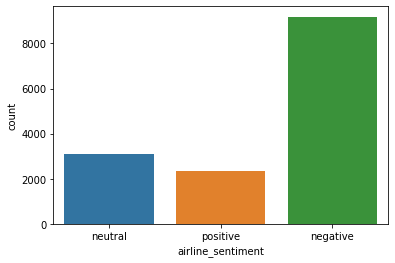

In [26]:
sns.(df['airline_sentiment'])

In [9]:
df['negativereason'].isnull().sum()

5462

In [10]:
df['negativereason'].isnull().sum() / len(df) * 100

37.30874316939891

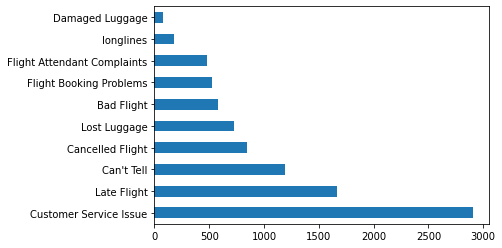

In [28]:
df['negativereason'].value_counts().plot(kind='barh')

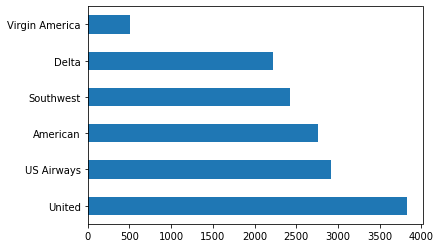

In [29]:
df['airline'].value_counts().plot(kind='barh')

In [32]:
df_sentiment = pd.crosstab(df['airline'],df['airline_sentiment'])
df_sentiment.head()

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492


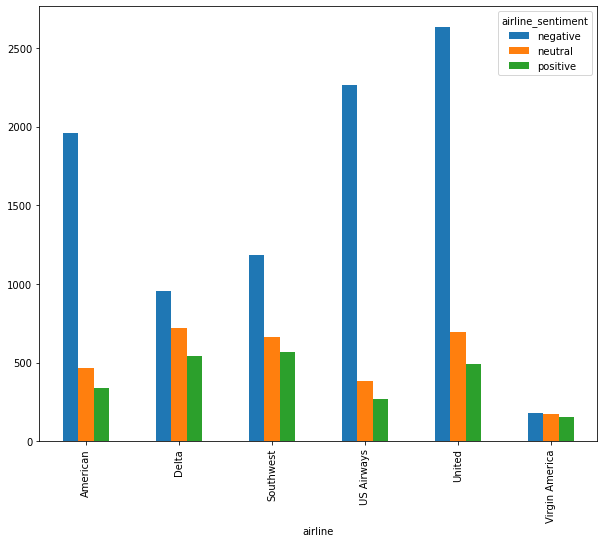

In [37]:

df_sentiment.plot(kind='bar', figsize=(10,8))

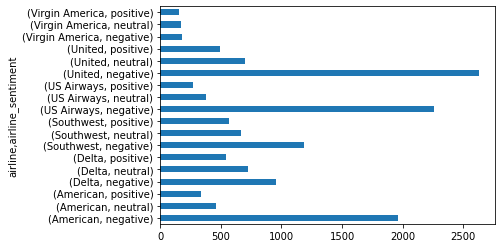

In [30]:
df.groupby(['airline','airline_sentiment'])['airline_sentiment'].count()

In [14]:
group = df.groupby(['airline','airline_sentiment'])

In [15]:
group.get_group(('United','negative'))['negativereason'].value_counts()

Customer Service Issue         681
Late Flight                    525
Can't Tell                     379
Lost Luggage                   269
Bad Flight                     216
Cancelled Flight               181
Flight Attendant Complaints    168
Flight Booking Problems        144
longlines                       48
Damaged Luggage                 22
Name: negativereason, dtype: int64

In [16]:
df.head()['tweet_created']

0    24/02/2015 11:35
1    24/02/2015 11:15
2    24/02/2015 11:15
3    24/02/2015 11:15
4    24/02/2015 11:14
Name: tweet_created, dtype: object

In [17]:
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
df.head()['tweet_created']

0   2015-02-24 11:35:00
1   2015-02-24 11:15:00
2   2015-02-24 11:15:00
3   2015-02-24 11:15:00
4   2015-02-24 11:14:00
Name: tweet_created, dtype: datetime64[ns]

In [18]:
df.groupby([df['tweet_created'].dt.date,'airline_sentiment'])['airline_sentiment'].count()

tweet_created  airline_sentiment
2015-02-16     negative                3
               neutral                 1
2015-02-17     negative              838
               neutral               297
               positive              273
2015-02-18     negative              736
               neutral               335
               positive              273
2015-02-19     negative              751
               neutral               329
               positive              296
2015-02-20     negative              835
               neutral               383
               positive              282
2015-02-21     negative             1049
               neutral               278
               positive              230
2015-02-22     negative             2266
               neutral               463
               positive              350
2015-02-23     negative             1919
               neutral               676
               positive              433
2015-02-24     negative 

In [19]:
airlines_performance = df.groupby(['airline','airline_sentiment'])['airline_sentiment'].count()
airlines_performance

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: airline_sentiment, dtype: int64

In [20]:
airlines = df['airline'].value_counts()
airlines.sort_index(inplace=True)
airlines

American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: airline, dtype: int64

In [21]:
for i in airlines_performance.index:
  if i[1] == 'positive':
    print(i[0],'- %', i[1], 'rating is:', end=' ')
    print(round(airlines_performance[i] / airlines[i[0]] * 100,2))

American - % positive rating is: 12.18
Delta - % positive rating is: 24.48
Southwest - % positive rating is: 23.55
US Airways - % positive rating is: 9.23
United - % positive rating is: 12.87
Virgin America - % positive rating is: 30.16


In [38]:
df = df[['airline_sentiment','text']]

In [39]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Text cleaning

In [43]:
stops = stopwords.words('english')

In [45]:
len(stops)

179

In [61]:
def text_cleaner(text):
  text = text.lower()
  text = re.sub('[^a-z]',' ',text)                #Regex Substituter - allowed words, replace with & text data
  words = text.split()
  words = [w for w in words if w not in stops] 
  return (' '.join(words))

In [64]:
doc = 'Here is a sample senTence. It is extEnded till here, and some more. @12334 #37465396'

In [65]:
text_cleaner(doc)

'sample sentence extended till'

In [51]:
df['cleaned_text'] = df['text'].apply(lambda x: text_cleaner(x))
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,airline_sentiment,text,cleaned_text
0,neutral,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said
1,positive,@VirginAmerica plus you've added commercials t...,virginamerica plus added commercials experienc...
2,neutral,@VirginAmerica I didn't today... Must mean I n...,virginamerica today must mean need take anothe...
3,negative,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,negative,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing


In [67]:
df['total_count'] = df['cleaned_text'].str.count(' ') + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
df.head()

,airline_sentiment,text,cleaned_text,total_count
0,neutral,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said,3
1,positive,@VirginAmerica plus you've added commercials t...,virginamerica plus added commercials experienc...,6
2,neutral,@VirginAmerica I didn't today... Must mean I n...,virginamerica today must mean need take anothe...,8
3,negative,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...,11
4,negative,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing,5


In [70]:
le = LabelEncoder()
df['airline_sentiment'] = le.fit_transform(df['airline_sentiment'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
df.head()

,airline_sentiment,text,cleaned_text,total_count
0,1,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said,3
1,2,@VirginAmerica plus you've added commercials t...,virginamerica plus added commercials experienc...,6
2,1,@VirginAmerica I didn't today... Must mean I n...,virginamerica today must mean need take anothe...,8
3,0,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...,11
4,0,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing,5


In [72]:
df.tail()

,airline_sentiment,text,cleaned_text,total_count
14635,2,@AmericanAir thank you we got on a different f...,americanair thank got different flight chicago,6
14636,0,@AmericanAir leaving over 20 minutes Late Flig...,americanair leaving minutes late flight warnin...,14
14637,1,@AmericanAir Please bring American Airlines to...,americanair please bring american airlines bla...,6
14638,0,"@AmericanAir you have my money, you change my ...",americanair money change flight answer phones ...,9
14639,1,@AmericanAir we have 8 ppl so we need 2 know h...,americanair ppl need know many seats next flig...,15


In [88]:
x = df['cleaned_text']
y = df['airline_sentiment']

In [89]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=50)

In [90]:
x_train.shape

(11712,)

In [91]:
y_train.shape

(11712,)

In [92]:
x_test.shape

(2928,)

In [93]:
y_test.shape

(2928,)

In [94]:
tf = TfidfVectorizer()

In [95]:
x_train_tf = tf.fit_transform(x_train)   # Applies transformation and learns the data
x_test_tf = tf.transform(x_test)         # Only applies transformation

In [96]:
len(tf.get_feature_names())

11926

In [98]:
x_train = scipy.sparse.csr_matrix.todense(x_train_tf)  # Converts sparse matrix to dense matrix
x_test = scipy.sparse.csr_matrix.todense(x_test_tf)

In [99]:
x_train.shape

(11712, 11926)

Building the Neural Architechture

In [100]:
x_neurons = x_train.shape[0]